# Cabled Seafloor Signals: Comparing Data Products BOTPT (RS03CCAL) and PREST (RS01SLBS)

**Evaluator:** W. Zach Billings

To check the quality of data, oftentimes comparison to an outside dataset is needed. Due to the diversity of products OOI produces, some products can be checked against others to provide a baseline idea of quality before comparing to outside products. In the case presented here, bottom pressures from two separate locations were compared: the Central Caldera, and the Oregon Slope Base Seafloor.

While separate, these two locations are close enough to each other that their tidal loading signals would have nearly identical phases; the main difference between the two signals would be in their amplitudes.

Two comparisons were made: the first is between three-year datasets; the second is a four-month window from the first datasets mentioned.

## First Comparison: 3-year datasets

I had trouble loading the BOTPT data over the three-year period when doing an asynchronous data request. As a result, I just did a synchronous request with the maximum limit (~20000). This provided a decent resolution (under 1.5 hours per datapoint), especially for a three-year period.

In [0]:
# Basic "constants" and packages needed for the code to run.
USERNAME = ""
TOKEN    = ""

PSI_TO_DECIBAR = 0.689476

import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [0]:
#FUNCTIONS:
# Time processing -- just stealing it from example 3
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

def find_midpoint(list1, list2):
    "Currently don't need the midpoint; keeping it in the function anyway."
    sum1 = 0
    for value in list1:
        sum1 += value
    sum2 = 0
    for value in list2:
        sum2 += value
    
    avg1 = sum1 / len(list1)
    avg2 = sum2 / len(list2)
    
    midpoint = (avg1 + avg2) / 2
    return (midpoint, avg1, avg2)

#def find_outline_upper(list1, ref_list, loop):
def find_outline_upper(list1, ref_list):
    """loop variable essentially tells system how many times you want to loop 
        through for better or worse envelope"""
    if len(list1) != len(ref_list):
        print("Inputted lists do not have the same length!")
        print("Function: find_outline_upper(list1,ref_list)")
        exit()
    
    
    outline_values = []
    new_reflist = []
    
    for i in range(1, (len(list1)-1)):
        if (list1[i] >= list1[i-1]) and (list1[i] >= list1[i+1]):
            outline_values.append(list1[i])
            new_reflist.append(ref_list[i])
    
#     if loop > 1:
#         for i in range(loop):
#             list1_altered = []
#             reflist_altered = []
            
#             for value in outline_values:
#                 list1_altered.append(value)
#             for value in new_reflist:
#                 reflist_altered.append(value)
                
#             outline_values = []
#             new_reflist = []
                
#             for j in range(1, (len(list1_altered)-1)):
#                 if (list1_altered[j] >= list1_altered[j-1]) and (list1_altered[j] >= list1_altered[j+1]):
#                     outline_values.append(list1_altered[j])
#                     new_reflist.append(reflist_altered[j])
        
    return outline_values, new_reflist

#def find_outline_lower(list1, ref_list, loop):
def find_outline_lower(list1, ref_list):
    """loop variable essentially tells system how many times you want to loop 
        through for better or worse envelope"""
    if len(list1) != len(ref_list):
        print("Inputted lists do not have the same length!")
        print("Function: find_outline_upper(list1,ref_list)")
        exit()
    
    
    outline_values = []
    new_reflist = []
    
    for i in range(1, (len(list1)-1)):
        if (list1[i] <= list1[i-1]) and (list1[i] <= list1[i+1]):
            outline_values.append(list1[i])
            new_reflist.append(ref_list[i])
    
#     if loop > 1:
#         for i in range(loop):
#             list1_altered = []
#             reflist_altered = []
#             for value in outline_values:
#                 list1_altered.append(value)
#             for value in new_reflist:
#                 reflist_altered.append(value)
                
#             outline_values = []
#             new_reflist = []
                
#             for j in range(1, (len(list1_altered)-1)):
#                 if (list1_altered[j] <= list1_altered[j-1]) and (list1_altered[j] <= list1_altered[j+1]):
#                     outline_values.append(list1_altered[j])
#                     new_reflist.append(reflist_altered[j])
        
    return outline_values, new_reflist


def find_median(input_list):
    i1 = len(input_list)//2 - 1
    i2 = i1+1
    if len(input_list)%2 == 0:
        median = (input_list[i1] + input_list[i2]) / 2
    else:
        median = input_list[i2]
    
    return median

def box_and_whisker(input_data, ref_list):
    #bt_transform = input_data, time1 = ref_list
    sorted_list = sorted(input_data)

    median = find_median(sorted_list)
    i1 = len(sorted_list)//2-1
    i2 = i1+1

    lower_half = sorted_list[:i2]
    upper_half = sorted_list[i2:]
    
#    print(lower_half)
#    print(upper_half)
    Q1 = find_median(lower_half)
    Q3 = find_median(upper_half)
    IQR = Q3 - Q1

    cutoff = IQR * 1.5
    lower_boundary = Q1 - cutoff
    upper_boundary = Q3 + cutoff

    outliers = []
    new_reflist = []
    for i in range(len(input_data)):
        if (input_data[i] > upper_boundary) or (input_data[i] < lower_boundary):
            outliers.append(input_data[i])
            new_reflist.append(ref_list[i])
            
    return (Q1, median, Q3, IQR, lower_boundary, upper_boundary, new_reflist, outliers)

In [0]:
# DEFINING DATA

limit = 20000

#Central Caldera
#RS03CCAL-MJ03F-05-BOTPTA301
# Depth:: 1526
site1       = "RS03CCAL"
node1       = "MJ03F"
instrument1 = "05-BOTPTA301"
method1     = "streamed"
stream1     = "botpt_nano_sample"

#Oregon Slope
# RS01SLBS-MJ01A-06-PRESTA101 
# Depth:: 2908
site2       = "RS01SLBS"
node2       = "MJ01A"
instrument2 = "06-PRESTA101"
method2     = "streamed"
stream2     = "prest_real_time"

# Parameters for length of time, dataset
params = {
  'beginDT':'2015-10-31T00:00:00.000Z',
  'endDT'  :'2018-10-31T00:00:00.000Z',
  'limit':limit,
  'minimum': 10000  
#  'format':'application/netcdf',
#  'include_provenance':'true',
#  'include_annotations':'true'
}

request_url1 = '/'.join((API_BASE_URL,site1,node1,instrument1,method1,stream1))
request_url2 = '/'.join((API_BASE_URL,site2,node2,instrument2,method2,stream2))

In [0]:
# REQUESTING DATA

#r1 = requests.get(request_url1, params=params, auth=(USERNAME, TOKEN))
#data1 = r1.json()

#r2 = requests.get(request_url2, params=params, auth=(USERNAME, TOKEN))
#data2 = r2.json()

In [0]:
data1[0]

{'preferred_timestamp': 'internal_timestamp',
 'sensor_id': 'NANO',
 'bottom_pressure_qc_executed': 29,
 'date_time_string': '2015/10/31 00:00:00.000',
 'port_timestamp': 3655238400.122046,
 'press_trans_temp': 2.79708796,
 'bottom_pressure_qc_results': 29,
 'ingestion_timestamp': 3655238400.922,
 'bottom_pressure': 2257.380615234375,
 'internal_timestamp': 3655238400.0,
 'time': 3655238400.0,
 'pk': {'node': 'MJ03F',
  'stream': 'botpt_nano_sample',
  'subsite': 'RS03CCAL',
  'deployment': 1,
  'time': 3655238400.0,
  'sensor': '05-BOTPTA301',
  'method': 'streamed'},
 'driver_timestamp': 3655238400.142639,
 'time_sync_flag': 'P'}

In [0]:
data2[0]

{'preferred_timestamp': 'port_timestamp',
 'seafloor_pressure_qc_results': 29,
 'seafloor_pressure_qc_executed': 29,
 'date_time_string': '2015-10-31T00:00:17',
 'port_timestamp': 3655238409.9928694,
 'absolute_pressure_qc_executed': 29,
 'sample_type': 'Pressure',
 'sample_number': 2434488,
 'ingestion_timestamp': 3655238411.156,
 'absolute_pressure_qc_results': 29,
 'pressure_temp': 1.7015000581741333,
 'internal_timestamp': 3655238417.0,
 'time': 3655238409.9928694,
 'pk': {'node': 'MJ01A',
  'stream': 'prest_real_time',
  'subsite': 'RS01SLBS',
  'deployment': 1,
  'time': 3655238409.9928694,
  'sensor': '06-PRESTA101',
  'method': 'streamed'},
 'driver_timestamp': 3655238410.223221,
 'seafloor_pressure': 2960.111195404078,
 'absolute_pressure': 4293.2783203125}

In [0]:
# Obtaining sets to plot/work with.

time1 = []
bt_pressure = []

time2 = []
sf_pressure = []

# The PREST data is in decibars, the BOTPT data is in psi (psia)
for i in range(len(data1)):
    time1.append(ntp_seconds_to_datetime(data1[i]['time']))
    bt_pressure.append(data1[i]['bottom_pressure'] * PSI_TO_DECIBAR)
for i in range(len(data2)):
    time2.append(ntp_seconds_to_datetime(data2[i]['time']))
    sf_pressure.append(data2[i]['seafloor_pressure'])

### Step 1: "Eyeball" check

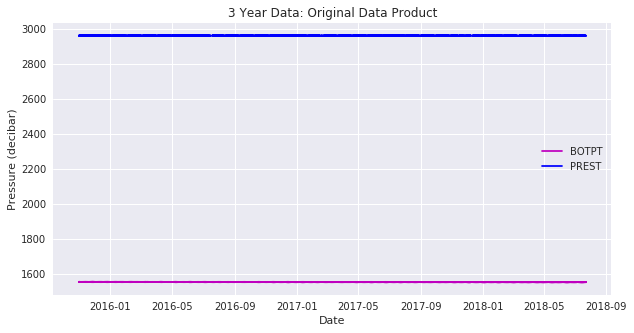

In [0]:
# PLOTTING: Original

sns.set()

# Oregon Slope ----- Blue
# Central Caldera -- Black

fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(time1, bt_pressure, 'm-', label="BOTPT")
ax.plot(time2, sf_pressure, 'b-', label="PREST")
ax.set_xlabel('Date')
ax.set_ylabel('Pressure (decibar)')
ax.legend(loc=7)
ax.set_title('3 Year Data: Original Data Product');

The Oregon plot is higher than the Caldera plot, which is essentially correct--Oregon is deeper, so it should be at a higher pressure.

The ratio of the depths should equal the ratio of the pressures -- essentially p1/p2 = (density1 * g * h1)/(density2 * g * h2) = h1/h2. These values check out as well at first glance.

There is a caveat with the Caldera data: since the BOTPT is on Axial Seamount, there should be some sign of inflation/deflation. When plotting this by itself, it can be seen clearly, especially when compared against the Oregon PREST data. Since the pressure is decreasing, this suggests that the instrument is rising and the seamount is inflating.

Text(0.5,1,'PREST Pressure Data')

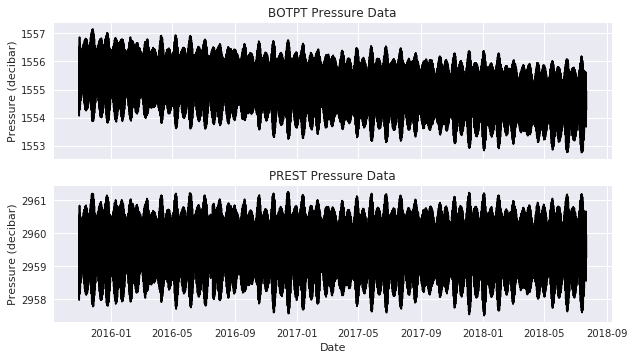

In [0]:
# PLOTTING: BOTPT

# Oregon Slope ----- Blue
# Central Caldera -- Red

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize=(10,5.5))
ax1.plot(time1, bt_pressure, 'k-')
ax2.plot(time2, sf_pressure, 'k-')
ax2.set_xlabel('Date')
ax1.set_ylabel('Pressure (decibar)')
ax2.set_ylabel('Pressure (decibar)')

ax1.set_title('BOTPT Pressure Data');
ax2.set_title('PREST Pressure Data')

### Step 2: Comparison between the plots

Because the BOTPT data is "tilted", it needs to be "flattened" in order to be compared to the PRESA data. A least-squares regression was applied to the BOTPT data; the value outputted by the linear regression line was then subtracted from the BOTPT data to flatten/center it around zero. (For the PREST data, the mean was subtracted).

In [0]:
# TRANSFORMATION: SHIFTING BOTPT TO STRAIGHT LINE--Least Squares

xs = []
ys = []

for i in range(len(time1)):
    xs.append(i)
xs = np.array(xs)

#for i in range(len(bt_pressure)):
#    ys.append(np.log(bt_pressure[i]))
#ys = np.array(ys)
ys = np.array(bt_pressure)

A = np.vstack([xs, np.ones(len(xs))]).T
m, c = np.linalg.lstsq(A, ys)[0]
print("y-int")
print(c)
print("slope")
print(m)

y-int
1555.6139112472615
slope
-5.2826722238672025e-05


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


In [0]:
# TRANSFORMATION: SHIFT
"""Basically, we're going to set both plots to be sitting on the same
    line. Instead of having them at a random place, we're going to set
    them both at y = 0."""
"""This is also going to make it easier to scale the plots to each other
    in the next 'step' in completing the transformation."""

avgs_data = find_midpoint(bt_pressure, sf_pressure)
midpoint = avgs_data[0]
bt_avg   = avgs_data[1]
sf_avg   = avgs_data[2]
shift = np.abs(midpoint - bt_avg)

#bt_locn = (bt_avg - c) / m
x_int = -c / m

bt_shift = []
sf_shift = []

for i in range(len(bt_pressure)):
    if xs[i] < x_int:
        bt_shift.append(bt_pressure[i] - ((m*xs[i] + c)))
    elif xs[i] > x_int:
        bt_shift.append(bt_pressure[i] + ((m*xs[i] + c)))
for value in sf_pressure:
    sf_shift.append(value - sf_avg) 

Text(0.5,1,'3 Year Data: Shifted Datasets')

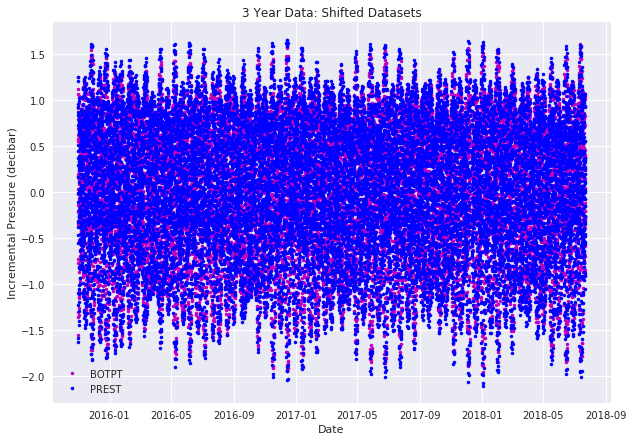

In [0]:
# PLOTTING: Shifted datasets

fig, (ax) = plt.subplots(figsize=(10,7))
ax.plot(time1, bt_shift, 'm.', label="BOTPT")
ax.plot(time2, sf_shift, 'b.', label="PREST")
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Pressure (decibar)')
ax.legend(loc=3)
ax.set_title('3 Year Data: Shifted Datasets')

### Step 3: Completing the transformation: final stretch

As can be seen above, the datasets are now overlapping. The next step is now to scale/stretch the amplitudes (i.e. "normalize" them to 1). This is relatively simple--each dataset is divided out by their respective maximum magnitude.


In [0]:
# TRANSFORMATION: STRETCH
"""Just finishing the transformation--essentially normalizing each plot."""

# TO FIND ABSOLUTE MAX (I.E. ABSOLUTE VALUE MAX)

# First finding the absolute values of each point, then finding the maximum magnitude.
bt_shift_MAX = np.abs(bt_shift[0])
for i in range(len(bt_shift)):
     if np.abs(bt_shift[i]) > bt_shift_MAX:
            bt_shift_MAX = np.abs(bt_shift[i])

sf_shift_MAX = np.abs(sf_shift[0])
for i in range(len(sf_shift)):
     if np.abs(sf_shift[i]) > sf_shift_MAX:
            sf_shift_MAX = np.abs(sf_shift[i])

bt_transform = []
sf_transform = []

# Finishing the transformation by stretching each plot
for value in bt_shift:
    bt_transform.append(value/bt_shift_MAX)
for value in sf_shift:
    sf_transform.append(value/sf_shift_MAX)

Text(0.5,1,'3 Year Data: Transformed Datasets')

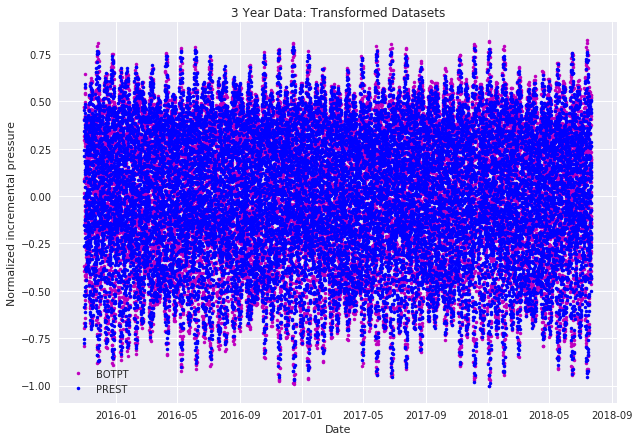

In [0]:
# PLOTTING: Complete transform

fig, (ax) = plt.subplots(figsize=(10,7))
ax.plot(time1, bt_transform, 'm.', label='BOTPT')
ax.plot(time2, sf_transform, 'b.', label="PREST")
ax.set_xlabel('Date')
ax.set_ylabel('Normalized incremental pressure')
ax.legend(loc=3)
ax.set_title('3 Year Data: Transformed Datasets')

The amplitudes of each signal matches the other (peak mathces peak, trough matches trough).

The next step now is to make this plot clearer.

### Step 4: Making Things Clearer

This plot will be made clearer in two ways:
    1. A rough envelope will be used to show the outline of the plot; and
    2. Potential outliers will be highlighted (i.e. spike test).
   
The envelope works by highlighting each maximum at the top of the plot, and each minimum at the bottom of the plot. An envelope can also be applied to the envelope (i.e. iterated twice).

In [0]:
# Here, two functions are being used to find the upper side of the envelope and the
#    lower side of the envelope.
# Originally, these were implemented as functions that iterated within themselves to output a final envelope.
#    There were two versions; both proved to have some issues. So, I removed the iterating part and
#    left the iterating to be implemented manually.
(bt_outline_upper1, bt_time_upper1) = find_outline_upper(bt_transform, time1)
(sf_outline_upper1, sf_time_upper1) = find_outline_upper(sf_transform, time2)
(bt_outline_lower1, bt_time_lower1) = find_outline_lower(bt_transform, time1)
(sf_outline_lower1, sf_time_lower1) = find_outline_lower(sf_transform, time2)

(bt_outline_upper2, bt_time_upper2) = find_outline_upper(bt_outline_upper1, bt_time_upper1)
(sf_outline_upper2, sf_time_upper2) = find_outline_upper(sf_outline_upper1, sf_time_upper1)
(bt_outline_lower2, bt_time_lower2) = find_outline_lower(bt_outline_lower1, bt_time_lower1)
(sf_outline_lower2, sf_time_lower2) = find_outline_lower(sf_outline_lower1, sf_time_lower1)

(bt_outline_upper3, bt_time_upper3) = find_outline_upper(bt_outline_upper2, bt_time_upper2)
(sf_outline_upper3, sf_time_upper3) = find_outline_upper(sf_outline_upper2, sf_time_upper2)
(bt_outline_lower3, bt_time_lower3) = find_outline_lower(bt_outline_lower2, bt_time_lower2)
(sf_outline_lower3, sf_time_lower3) = find_outline_lower(sf_outline_lower2, sf_time_lower2)

#print("coffee")

Text(0.5,1,'3 Year Data: Envelope, 3 Iterations')

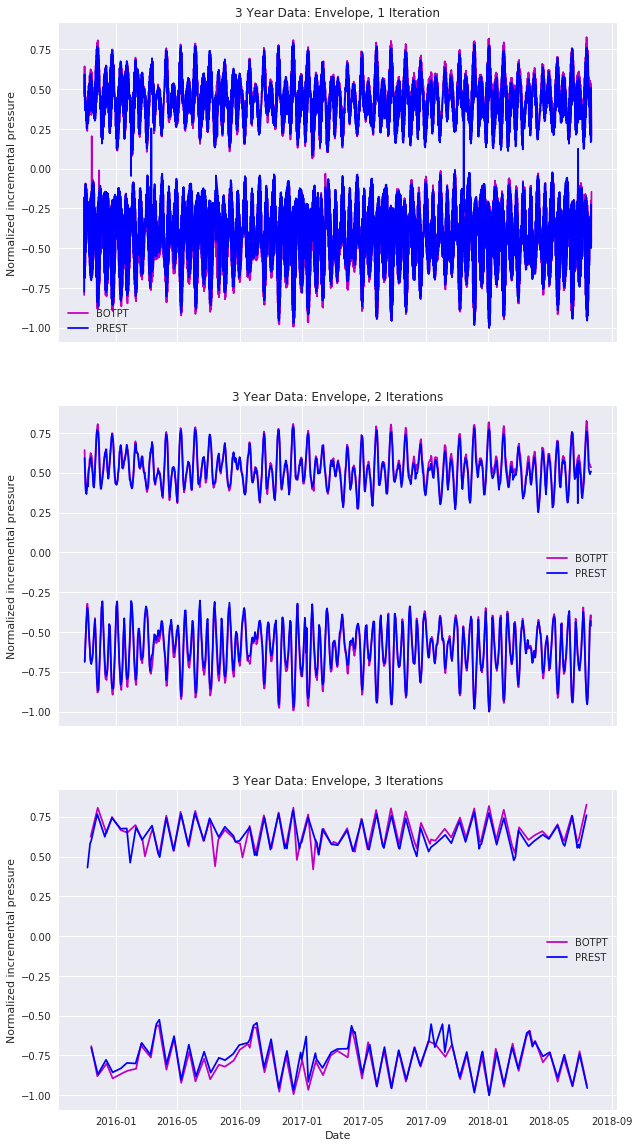

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,20))
ax1.plot(bt_time_upper1, bt_outline_upper1, 'm-', label="BOTPT")
ax1.plot(sf_time_upper1, sf_outline_upper1, 'b-', label="PREST")
ax1.plot(bt_time_lower1, bt_outline_lower1, 'm-')
ax1.plot(sf_time_lower1, sf_outline_lower1, 'b-')

ax2.plot(bt_time_upper2, bt_outline_upper2, 'm-', label="BOTPT")
ax2.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="PREST")
ax2.plot(bt_time_lower2, bt_outline_lower2, 'm-')
ax2.plot(sf_time_lower2, sf_outline_lower2, 'b-')

ax3.plot(bt_time_upper3, bt_outline_upper3, 'm-', label="BOTPT")
ax3.plot(sf_time_upper3, sf_outline_upper3, 'b-', label="PREST")
ax3.plot(bt_time_lower3, bt_outline_lower3, 'm-')
ax3.plot(sf_time_lower3, sf_outline_lower3, 'b-')

ax3.set_xlabel('Date')
ax1.set_ylabel('Normalized incremental pressure')
ax2.set_ylabel('Normalized incremental pressure')
ax3.set_ylabel('Normalized incremental pressure')
ax1.legend(loc=3)
ax2.legend(loc=7)
ax3.legend(loc=7)
ax1.set_title('3 Year Data: Envelope, 1 Iteration')
ax2.set_title('3 Year Data: Envelope, 2 Iterations')
ax3.set_title('3 Year Data: Envelope, 3 Iterations')

#ax2.plot(datetime.datetime(2016, 3, 10, 17,16,0), 0, 'yo')



Note that, in the top plot ("3 Year Data: Envelope") the  two signals generally match, but there are a few exceptions that seem to "stick" out. As more iterations of the envelope are applied, the plots generally fit, but they still disagree in a few places; this could be due to the randomness of the points selected by the data request, as none seem to correspond to any annotations.

### Final Step: Looking for outliers.

Basic qualitative statistics were also used to try to identify outliers. Essentially, the median, first quartile, and third quartile were identified; from there a range for outliers was identified. A function was created to output all of these parameters, as well as a list of outliers.


In [0]:
# Qualitative stats:

bt_upper_baw = box_and_whisker(bt_outline_upper1, bt_time_upper1)
bt_lower_baw = box_and_whisker(bt_outline_lower1, bt_time_lower1)
sf_upper_baw = box_and_whisker(sf_outline_upper1, sf_time_upper1)
sf_lower_baw = box_and_whisker(sf_outline_lower1, sf_time_lower1)

bt_transform_baw = box_and_whisker(bt_transform, time1)
sf_transform_baw = box_and_whisker(sf_transform, time2)

print(len(bt_transform_baw[-1]))
print(len(sf_transform_baw[-1]))

0
0


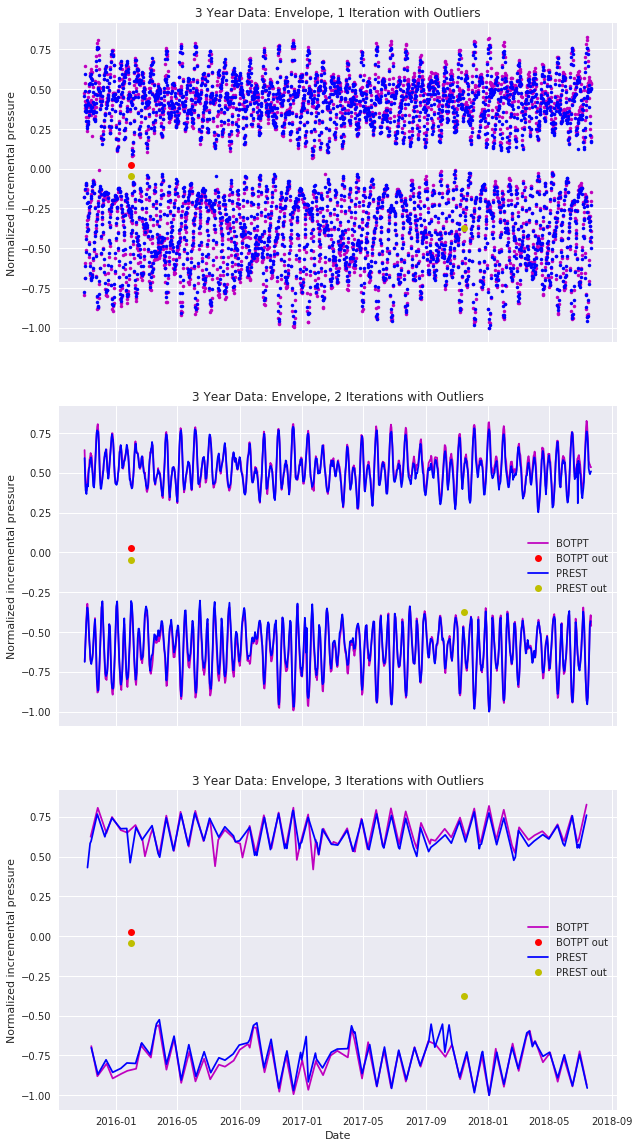

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,20))

#ax.plot(bt_time_upper1, bt_outline_upper1, 'b-')
#ax.plot(bt_upper_baw[-2],bt_upper_baw[-1], 'ro')

ax1.plot(bt_time_upper1, bt_outline_upper1, 'm.', label="BOTPT")
ax1.plot(bt_time_lower1, bt_outline_lower1, 'm.')
ax1.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro')
ax1.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

ax1.plot(sf_time_upper1, sf_outline_upper1, 'b.', label="PREST")
ax1.plot(sf_time_lower1, sf_outline_lower1, 'b.')
ax1.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo')
ax1.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')

ax2.plot(bt_time_upper2, bt_outline_upper2, 'm-', label="BOTPT")
ax2.plot(bt_time_lower2, bt_outline_lower2, 'm-')
ax2.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro', label="BOTPT out")
ax2.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

ax2.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="PREST")
ax2.plot(sf_time_lower2, sf_outline_lower2, 'b-')
ax2.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo', label="PREST out")
ax2.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')

ax3.plot(bt_time_upper3, bt_outline_upper3, 'm-', label="BOTPT")
ax3.plot(bt_time_lower3, bt_outline_lower3, 'm-')
ax3.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro', label="BOTPT out")
ax3.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

ax3.plot(sf_time_upper3, sf_outline_upper3, 'b-', label="PREST")
ax3.plot(sf_time_lower3, sf_outline_lower3, 'b-')
ax3.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo', label="PREST out")
ax3.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')


ax3.set_xlabel('Date')
ax1.set_ylabel('Normalized incremental pressure')
ax2.set_ylabel('Normalized incremental pressure')
ax3.set_ylabel('Normalized incremental pressure')
ax1.set_title('3 Year Data: Envelope, 1 Iteration with Outliers')
ax2.set_title('3 Year Data: Envelope, 2 Iterations with Outliers')
ax3.set_title('3 Year Data: Envelope, 3 Iterations with Outliers')

#ax1.legend(loc=7)
ax2.legend(loc=7)
ax3.legend(loc=7)

When checking for outliers across the full datasets (i.e. no envelope applied), no outliers appear. However, this can be misleading, as looking for outliers a box and whisker plot/method will only indicate if *peak* outliers exist; it will not indicate whether a given *trough* is an outlier. To get around this, the upper and lower outlines of a given envelope can be checked instead; this is what is plotted by the red (BOTPT) and yellow (PREST) points in the plots.

While the outliers do not necessarily align with the annotations, they are consistent to some degree. Even as the envelope is iterated, the outliers (represented by the red [BOTPT] and yellow [PRESA] dots), still align with what could be anomalous peaks/troughs. The outliers found do not align with any annotations; they also do not seem to be large outliers. Across severla synchronous requests, most of the outliers appear and disappear--the only ones that seem consistent across requests are located at 2016 January 31. These do not seem to correspond to any specific seismic event (Earthquake Canada). While this could be due to a pressure signal in the water (acoustic signal?), the low frequency acoustic hydrophone (RS03CCAL-MJ03F-06-HYDLFA305) is not available on the main OOI site (oceanobservatories.org) at this time.

Another potentially better way to check for outliers would be to find the difference between the two sets, *then* check for outliers. That was not pursued here because the datasets do not have the same number of points, nor do they necessarily correspond to the same dates/times. While they cover the same span of time, the points are distributed differently across that span. The difference thus cannot be found as a straight subtraction between the two sets.

## Four month datasets

A four month period was analyzed in a similar way; with a shorter period, more precision can be had when requesting data synchronously.

In [0]:
# DEFINING DATA

#Central Caldera
#RS03CCAL-MJ03F-05-BOTPTA301
site11       = "RS03CCAL"
node11       = "MJ03F"
instrument11 = "05-BOTPTA301"
method11     = "streamed"
stream11     = "botpt_nano_sample"

#Oregon Slope
# RS01SLBS-MJ01A-06-PRESTA101 
site22       = "RS01SLBS"
node22       = "MJ01A"
instrument22 = "06-PRESTA101"
method22     = "streamed"
stream22     = "prest_real_time"

# Parameters for length of time, dataset
params2 = {
  'beginDT':'2016-01-01T00:00:00.000Z',
  'endDT':'2016-04-01T00:00:00.000Z',
  'limit':6000,
#  'format':'application/netcdf',
#  'include_provenance':'true',
#  'include_annotations':'true'
}

request_url11 = '/'.join((API_BASE_URL,site11,node11,instrument11,method11,stream11))
request_url22 = '/'.join((API_BASE_URL,site22,node22,instrument22,method22,stream22))


In [0]:
# REQUESTING DATA

#r11 = requests.get(request_url11, params=params2, auth=(USERNAME, TOKEN))
#data11 = r11.json()

#r22 = requests.get(request_url22, params=params2, auth=(USERNAME, TOKEN))
#data22 = r22.json()

As before, each dataset was shifted to be centered about zero and normalized. Due to the relatively short time period, the BOTPT data does not need to be refitted or 'flattened" to follow a horizontal line as before; the effects of Axial Seamount's inflation/deflation are negligible. Each point represents roughly a half hour period.

In [0]:
# Obtaining sets to plot

time11 = []
bt_pressure1 = []
time22 = []
sf_pressure2 = []

# As before, BOTPT originally was in psi, PRESA was in decibars.
for i in range(len(data11)):
    time11.append(ntp_seconds_to_datetime(data11[i]['time']))
    bt_pressure1.append(data11[i]['bottom_pressure'] * PSI_TO_DECIBAR)
    
for i in range(len(data22)):
    time22.append(ntp_seconds_to_datetime(data22[i]['time']))
    sf_pressure2.append(data22[i]['seafloor_pressure'])

Text(0.5,1,'4 Month Data: Original Data Products')

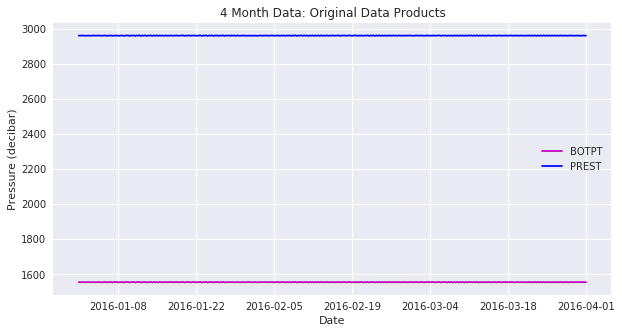

In [0]:
# PLOTTING: Original

sns.set()

# Oregon Slope ----- Blue
# Central Caldera -- Magenta

fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(time11, bt_pressure1, 'm-', label="BOTPT")
ax.plot(time22, sf_pressure2, 'b-', label="PREST")
ax.set_xlabel('Date')
ax.set_ylabel('Pressure (decibar)')
ax.legend(loc=7)
ax.set_title('4 Month Data: Original Data Products')

In [0]:
# TRANSFORMATION: SHIFT
"""Basically, we're going to set both plots to be sitting on the same
    line. Instead of having them at a random place, we're going to set
    them both at y = 0."""
"""This is also going to make it easier to scale the plots to each other
    in the next 'step' in completing the transformation."""

avgs_data = find_midpoint(bt_pressure1, sf_pressure2)
midpoint = avgs_data[0]
bt_avg   = avgs_data[1]
sf_avg   = avgs_data[2]
shift = np.abs(midpoint - bt_avg)

bt_shift = []
sf_shift = []

for value in bt_pressure1:
    bt_shift.append(value - bt_avg)
for value in sf_pressure2:
    sf_shift.append(value - sf_avg)  

Text(0.5,1,'4 Month Data: Shifted Data')

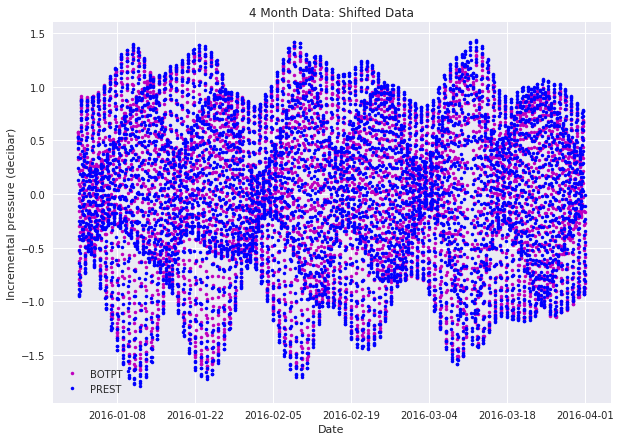

In [0]:
# PLOTTING: Shifted

fig, (ax) = plt.subplots(figsize=(10,7))
ax.plot(time11, bt_shift, 'm.', label="BOTPT")
ax.plot(time22, sf_shift, 'b.', label="PREST")
ax.set_xlabel('Date')
ax.set_ylabel('Incremental pressure (decibar)')
ax.legend(loc=3)
ax.set_title('4 Month Data: Shifted Data')

In [0]:
# TRANSFORMATION: STRETCH
"""Just finishing the transformation--scaling each plot to their largest magnitude value"""

abs_bt_shift = []
abs_sf_shift = []

for value in bt_shift:
    abs_bt_shift.append(np.abs(value))
for value in sf_shift:
    abs_sf_shift.append(np.abs(value))
    

bt_shift_MAX = sorted(abs_bt_shift)[-1]
sf_shift_MAX = sorted(abs_sf_shift)[-1]

bt_transform = []
sf_transform = []

for value in bt_shift:
    bt_transform.append(value/bt_shift_MAX)
for value in sf_shift:
    sf_transform.append(value/sf_shift_MAX)

Text(0.5,1,'4 Month Data: Transformed Data')

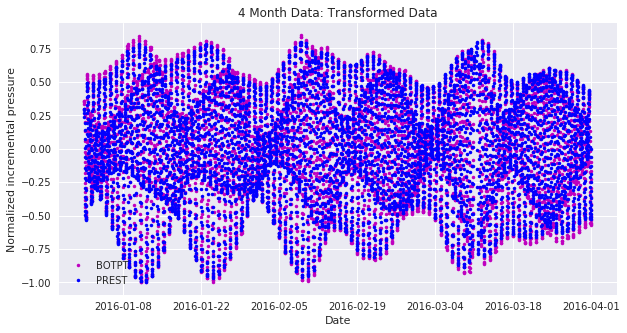

In [0]:
# PLOTTING: Complete transform

fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(time11, bt_transform, 'm.',label="BOTPT")
ax.plot(time22, sf_transform, 'b.',label="PREST")
ax.set_xlabel('Date')
ax.legend(loc=3)
ax.set_ylabel('Normalized incremental pressure')
ax.set_title('4 Month Data: Transformed Data')

In [0]:
(bt_outline_upper1, bt_time_upper1) = find_outline_upper(bt_transform, time11)
(sf_outline_upper1, sf_time_upper1) = find_outline_upper(sf_transform, time22)

(bt_outline_lower1, bt_time_lower1) = find_outline_lower(bt_transform, time11)
(sf_outline_lower1, sf_time_lower1) = find_outline_lower(sf_transform, time22)

Text(0.5,1,'4 Month Data: Envelope, 1 Iteration')

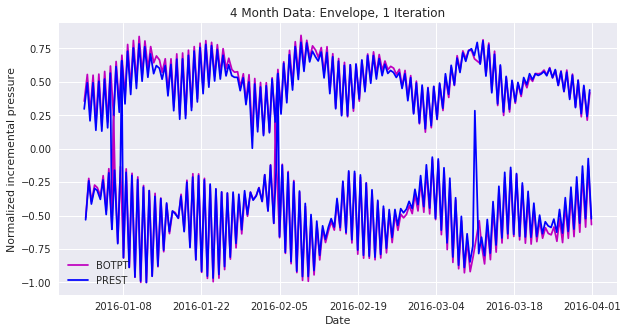

In [0]:
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(bt_time_upper1, bt_outline_upper1, 'm-', label='BOTPT')
ax.plot(sf_time_upper1, sf_outline_upper1, 'b-', label='PREST')
ax.plot(bt_time_lower1, bt_outline_lower1, 'm-')
ax.plot(sf_time_lower1, sf_outline_lower1, 'b-')

ax.set_xlabel('Date')
ax.set_ylabel('Normalized incremental pressure')
ax.legend(loc=3)
ax.set_title('4 Month Data: Envelope, 1 Iteration')

Text(0.5,1,'4 Month Data: Envelope, 2 Iteration')

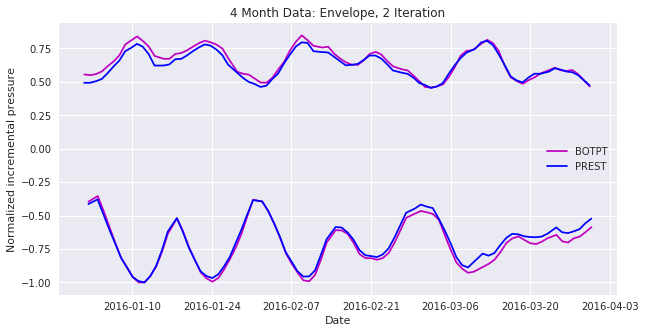

In [0]:
(bt_outline_upper2, bt_time_upper2) = find_outline_upper(bt_outline_upper1, bt_time_upper1)
(sf_outline_upper2, sf_time_upper2) = find_outline_upper(sf_outline_upper1, sf_time_upper1)

(bt_outline_lower2, bt_time_lower2) = find_outline_lower(bt_outline_lower1, bt_time_lower1)
(sf_outline_lower2, sf_time_lower2) = find_outline_lower(sf_outline_lower1, sf_time_lower1)

fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(bt_time_upper2, bt_outline_upper2, 'm-',label="BOTPT")
ax.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="PREST")
ax.plot(bt_time_lower2, bt_outline_lower2, 'm-')
ax.plot(sf_time_lower2, sf_outline_lower2, 'b-')

ax.set_xlabel('Date')
ax.set_ylabel('Normalized incremental pressure')
ax.legend(loc=7)
ax.set_title('4 Month Data: Envelope, 2 Iteration')

Text(0.5,1,'4 Month Data: Envelope, Combined Plots')

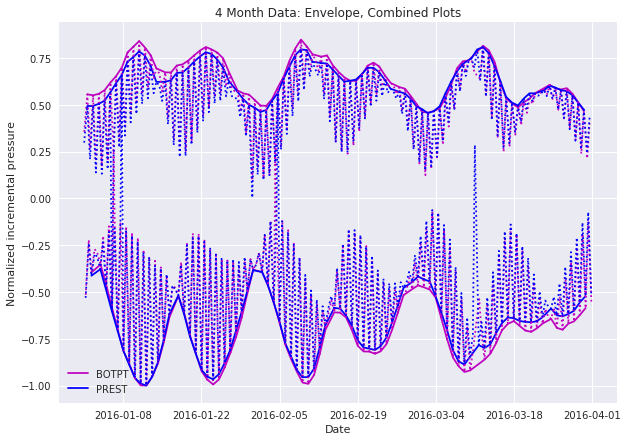

In [0]:
fig, (ax) = plt.subplots(figsize=(10,7))
ax.plot(bt_time_upper2, bt_outline_upper2, 'm-', label="BOTPT")
ax.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="PREST")
ax.plot(bt_time_lower2, bt_outline_lower2, 'm-')
ax.plot(sf_time_lower2, sf_outline_lower2, 'b-')
ax.plot(bt_time_upper1, bt_outline_upper1, 'm:')
ax.plot(sf_time_upper1, sf_outline_upper1, 'b:')
ax.plot(bt_time_lower1, bt_outline_lower1, 'm:')
ax.plot(sf_time_lower1, sf_outline_lower1, 'b:')


# ax1.plot(bt_time_upper1, bt_outline_upper1, 'm.', label="BOTPT")
# ax1.plot(bt_time_lower1, bt_outline_lower1, 'm.')
# ax1.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro')
# ax1.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

# ax1.plot(sf_time_upper1, sf_outline_upper1, 'b.', label="PRESA")
# ax1.plot(sf_time_lower1, sf_outline_lower1, 'b.')
# ax1.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo')
# ax1.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')

# ax2.plot(bt_time_upper2, bt_outline_upper2, 'm-', label="BOTPT")
# ax2.plot(bt_time_lower2, bt_outline_lower2, 'm-')
# ax2.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro')
# ax2.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

# ax2.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="BOTPT")
# ax2.plot(sf_time_lower2, sf_outline_lower2, 'b-')
# ax2.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo')
# ax2.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')

# ax3.plot(bt_time_upper3, bt_outline_upper3, 'm-', label="BOTPT")
# ax3.plot(bt_time_lower3, bt_outline_lower3, 'm-')
# ax3.plot(bt_upper_baw[-2], bt_upper_baw[-1], 'ro')
# ax3.plot(bt_lower_baw[-2],bt_lower_baw[-1], 'ro')

# ax3.plot(sf_time_upper3, sf_outline_upper3, 'b-', label="BOTPT")
# ax3.plot(sf_time_lower3, sf_outline_lower3, 'b-')
# ax3.plot(sf_upper_baw[-2],sf_upper_baw[-1], 'yo')
# ax3.plot(sf_lower_baw[-2], sf_lower_baw[-1], 'yo')

ax.legend(loc=3)
ax.set_xlabel('Date')
ax.set_ylabel('Normalized incremental pressure')
ax.set_title('4 Month Data: Envelope, Combined Plots')

The above plot combines both the 1-iteration and 2-iterations from the previous plots.

[datetime.datetime(2016, 1, 31, 2, 59, 59)]


Text(0.5,1,'4 Month Data: Envelope, Combined Plots with Outliers')

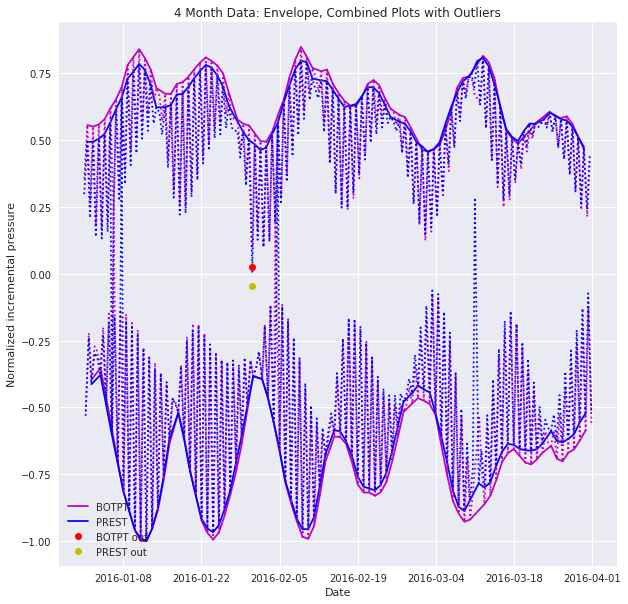

In [0]:
fig, (ax) = plt.subplots(figsize=(10,10))
ax.plot(bt_time_upper2, bt_outline_upper2, 'm-',label="BOTPT")
ax.plot(sf_time_upper2, sf_outline_upper2, 'b-', label="PREST")
ax.plot(bt_time_lower2, bt_outline_lower2, 'm-')
ax.plot(sf_time_lower2, sf_outline_lower2, 'b-')
ax.plot(bt_time_upper1, bt_outline_upper1, 'm:')
ax.plot(sf_time_upper1, sf_outline_upper1, 'b:')
ax.plot(bt_time_lower1, bt_outline_lower1, 'm:')
ax.plot(sf_time_lower1, sf_outline_lower1, 'b:')

ax.plot(bt_upper_baw[-2][0], bt_upper_baw[-1][0], 'ro', label='BOTPT out')
ax.plot(sf_upper_baw[-2][0],sf_upper_baw[-1][0], 'yo', label='PREST out')

print(bt_upper_baw[-2])

#ax.plot(datetime.datetime(2016,2,4,12,0,0), 0, 'ko')

ax.legend(loc=3)
ax.set_xlabel('Date')
ax.set_ylabel('Normalized incremental pressure')
ax.set_title('4 Month Data: Envelope, Combined Plots with Outliers')


With the transformations and the iterations of the envelopes dones, we can take a closer look. The datasets from the two instruments agree at a smaller scale. The outliers from the BOTPT data (red) and PRESA data (yellow) from the 3-year period are plotted for comparison as well. While they do appear at a lower than normal trough, this probably is not anything abormal.

Notice, however, the spike around 10 March 2016. This did not correspond to any outliers from the 3-year period--though if we applied the same qualitative statistical analysis here, it would definitely stand out. In terms of timing, this spike occurs at the same time as a break in the fiber optic cable between Portland and Seattle. This may be the cause for it; when looking back at the unenveloped plots, one can see a gap at the same location. While the spike does not necessarily appear for the BOTPT data in the plot, a clear gap can still be seen. The spike/gap at this date has been consistent for every synchronous request for the data made.

A few other spikes appear as well that do not always appear over multiple requests. Multiple spikes appear at 06 January 2016 and 07 January 2016. There is an annotation for four 1-minute outages due to maintenance on 07 January that could correspond to this; since these do not always appear when data is requested synchronously suggests that there are fewer datapoints to be selected from.

Another set of spikes appear at 04 February 2018. This does not correspond to any annotations from either dataset, even for other instruments within the same areas. The annotated spikes both occur during times of outages/breaks; the February spike may be due to similar reasons. That both datasets spike suggests it is affecting the cable, rather than individual instruments.

## Conclusions and Anything of Note

*"Dull science is good science." -- Bern McKiernan *

By comparing the datasets, it can be determined that they are fairly consistent. When downsampling to bihourly, hourly, or half-hour intervals, both sets are fairly continuous. While a gap test cannot be applied (due to the randomness of the data), a spike test (in the form of qualitative statistical analysis *and* a visual check) can be applied. When visually checking the data, a spike test applied to envelopes may be more effective than a gap test, as shorter-scale gaps may not be obvious.

Apart from differences due to the randomness of the point selection, small differences may also be due to differences in topography affecting the movement of water as well as differences in seismic activity.